In [1]:
#this code reads in the MMD, just lat, lon, time and interpolates CCMP for each matchup
import datetime as dt
from datetime import datetime
import numpy as np
import math
import os
#import sys
import pandas as pd
import xarray as xr
from netCDF4 import Dataset  
####################you will need to change some paths here!#####################
dir_mmdb='F:/data/mmd/mmd06c_re01_pp/drifter-sst_amsre-aq/' 
dir_mmdb_ccmp='f:/data/mmd/mmd06c_re01_pp/wind/' 
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y' 
#################################################################################
input_year=2003
input_month=1

In [2]:
#istart_flag = 0 
#for root, dirs, files in os.walk(dir_mmdb, topdown=False):
#    for name in files:
#        if name.endswith(".nc"):
filename_mmdb=dir_mmdb+'mmd06c_sst_drifter-sst_amsre-aq_2002-152_2002-158.nc'
filename_mmdb_ccmp=dir_mmdb_ccmp+'ccmp_mmd06c_sst_drifter-sst_amsre-aq_2002-152_2002-158.nc'
ds=xr.open_dataset(filename_mmdb,decode_times=False)


C:\Users\gentemann\Anaconda3\lib\site-packages\xarray\conventions.py:362: SerializationWarning: variable 'amsre.land_ocean_flag_6' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  stack_char_dim=stack_char_dim)
C:\Users\gentemann\Anaconda3\lib\site-packages\xarray\conventions.py:362: SerializationWarning: variable 'amsre.percent_land' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  stack_char_dim=stack_char_dim)


In [3]:
ds['amsre.time']

<xarray.DataArray 'amsre.time' (matchup_count: 23720, amsre-aq_ny: 21, amsre-aq_nx: 21)>
[10460520 values with dtype=float64]
Dimensions without coordinates: matchup_count, amsre-aq_ny, amsre-aq_nx
Attributes:
    _CoordinateAxisType:  Time
    units:                seconds since 1993-01-01T00:00:00Z
    calendar:             TAI

In [14]:
#ds_test = xr.DataArray(ds['amsre.percent_land'][:,10,10],
#   ....:                   coords={'lat': ('lat', ds['amsre.latitude'][:,10,10]),
#   ....:                           'lon': ('lon', ds['amsre.longitude'][:,10,10])},
#   ....:                   dims=['lat','lon'])
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
FLOAT_FILLVALUE = np.finfo(np.float32).min
DOUBLE_FILLVALUE = np.finfo(np.float64).min
dtime = ds['amsre.time'][:,10,10]
data = ds['amsre.percent_land'][:,10,10]
lat = ds['amsre.latitude'][:,10,10].values
lon =ds['amsre.longitude'][:,10,10].values
#foo = xr.DataArray(data, coords=[lat,lon], dims=['lat', 'lon'])
#plt.figure(figsize=(7,2));
#ax = plt.axes(projection=ccrs.PlateCarree())
#data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),x=lon, y=lat);
vattrs = ds['amsre.brightness_temperature10H'].attrs.copy()
varrays = {}
COORD_ATTR = 'lat lon time'
vattrs["coordinates"] = COORD_ATTR
vattrs = ds['amsre.longitude'].attrs.copy()
vattrs["_FillValue"] = FLOAT_FILLVALUE
values = np.ma.fix_invalid(lon)
#varrays['lon'] = xr.DataArray(values.filled(FLOAT_FILLVALUE).astype(np.float32,copy=False),dims=['time'],attrs=vattrs)
vattrs = ds['amsre.latitude'].attrs.copy()
vattrs["_FillValue"] = FLOAT_FILLVALUE
values = np.ma.fix_invalid(lat)
#varrays['lat'] = xr.DataArray(values.filled(FLOAT_FILLVALUE).astype(np.float32,copy=False),dims=['time'],attrs=vattrs)
varrays['percent_land'] = xr.DataArray(data.astype(np.float32,copy=False),dims=['time'],attrs=vattrs)
values = np.ma.fix_invalid(dtime.values)
vtime = xr.DataArray(values.filled(FLOAT_FILLVALUE).astype(np.float64,copy=False),dims=['time'],attrs=vattrs)
ds_test = xr.Dataset(varrays,coords = {'time': vtime, 'lon':lon, 'lat':lat})



In [16]:
#ds['amsre.latitude'][:,10,10]
ds.data_vars
ds['amsre.longitude'].attrs
ds_test


<xarray.Dataset>
Dimensions:       (lat: 23720, lon: 23720, time: 23720)
Coordinates:
  * lat           (lat) float32 39.614376 39.59646 39.614376 39.614376 ...
  * lon           (lon) float32 -72.345894 -72.44433 -72.345894 -72.345894 ...
  * time          (time) float64 2.973e+08 2.973e+08 2.973e+08 2.973e+08 ...
Data variables:
    percent_land  (time) float32 0.0 0.0 0.0 0.0 28.0 28.0 28.0 28.0 28.0 ...

In [28]:
dataset=ds
# convert names
COORD_ATTR = 'lat lon time'
#COORD_ATTR = 'time'
FLOAT_FILLVALUE = np.finfo(np.float32).min
DOUBLE_FILLVALUE = np.finfo(np.float64).min
VAR_TRANSLATE = {
   # 'amsre.latitude': 'lat',
   # 'amsre.longitude': 'lon',
    'amsre.brightness_temperature6V': 'tb6v',
    'amsre.brightness_temperature6H': 'tb6h',
    'amsre.percent_land':'percent_land'
}
# copy variables from source dataset
varrays = {}
for v in dataset.data_vars:
    if v in VAR_TRANSLATE:
       # print(v)
        # set attributes
        vattrs = dataset[v].attrs.copy()
        if v not in ['amsre.latitude', 'amsre.longitude', 'amsre.time']:
            vattrs["coordinates"] = COORD_ATTR
        vattrs["_FillValue"] = FLOAT_FILLVALUE
        
        values = np.ma.fix_invalid(dataset[v].values[:,10,10])
        # create new data array
        varrays[VAR_TRANSLATE[v]] = xr.DataArray(
            values.filled(FLOAT_FILLVALUE).astype(np.float32,copy=False),
            dims=['time'],
            attrs=vattrs
        )

      
# 1. wind speed
vattrs = dataset['amsre.nwp.10m_east_wind_component'].attrs.copy()
vattrs['standard_name'] = 'wind_speed'
vattrs['long_name'] = 'wind_speed'
vattrs['valid_min'] = 0
vattrs['valid_max'] = 100
vattrs["_FillValue"] = FLOAT_FILLVALUE
vattrs["coordinates"] = COORD_ATTR
WS_10m=(dataset['amsre.nwp.10m_east_wind_component'].values[:,2,2]**2 + dataset['amsre.nwp.10m_north_wind_component'].values[:,2,2]**2)**.5
varrays['wind_speed'] = xr.DataArray(
    WS_10m.astype(np.float32,copy=False),
    dims=['time'],
    attrs=vattrs
    )

# 2. wind direction
vattrs = dataset['amsre.nwp.10m_east_wind_component'].attrs.copy()
vattrs['standard_name'] = 'wind_to_direction'
vattrs['long_name'] = 'local wind direction'
vattrs['valid_min'] = 0
vattrs['valid_max'] = 360
vattrs["_FillValue"] = FLOAT_FILLVALUE
vattrs['units'] = 'degrees'
vattrs["coordinates"] = COORD_ATTR
WD=np.arctan2(dataset['amsre.nwp.10m_east_wind_component'].values[:,2,2], dataset['amsre.nwp.10m_east_wind_component'].values[:,2,2])*180/3.14159
WD=np.where(WD<0,WD+360,WD)
varrays['wind_direction'] = xr.DataArray(
    WD.astype(np.float32,copy=False),
    dims=['time'],
    attrs=vattrs
    )

# 3. time
vattrs = ds['amsre.time'].attrs.copy()
vattrs["_FillValue"] = DOUBLE_FILLVALUE
values = np.ma.fix_invalid(ds['amsre.time'].values[:,10,10])
vtime = xr.DataArray(
    values.filled(FLOAT_FILLVALUE).astype(np.float64,copy=False),
    dims=['time'],
    attrs=vattrs
    )

# create Dataset and save
l3r = xr.Dataset(varrays,coords = {'time': vtime, 'lon':lon, 'lat':lat})
#l3r = xr.Dataset(varrays,coords = { 'lon':lon, 'lat':lat})

# embellishments

#indicative_date_time=pd.to_datetime(str(time_usv[0].data)).strftime("%Y%m%d%H%M%S")
#Product_string = astr_platform #   str(ds.TEMP_CTD_MEAN.vendor_name) + '_' + str(ds.TEMP_CTD_MEAN.serial_number)
#filename_L3R = dir_out + indicative_date_time + \
#    '-' + ISDP + '-' + 'L3R' + '-' + SST_type + '-' +Product_string+ '-v' +Annex_version+ '-fv' +File_version+ '.nc'
#filename_L3R_test = dir_out + indicative_date_time + \
#    '-' + ISDP + '-' + 'L3R' + '-' + SST_type + '-' +Product_string+ '-v' +Annex_version+ '-fv' +File_version+ 'test.nc'
#filename_L3R
#l3r.to_netcdf(filename_L3R)
#for some reason the time not decoded is off by about 28 seconds so reset to original decoded time here
#l3r['time']=ds.time[0,:].data                 
#l3r.to_netcdf(filename_L3R)


In [29]:
l3r

<xarray.Dataset>
Dimensions:         (lat: 23720, lon: 23720, time: 23720)
Coordinates:
  * lat             (lat) float32 39.614376 39.59646 39.614376 39.614376 ...
  * lon             (lon) float32 -72.345894 -72.44433 -72.345894 -72.345894 ...
  * time            (time) float64 2.973e+08 2.973e+08 2.973e+08 2.973e+08 ...
Data variables:
    wind_speed      (time) float32 3.7131388 3.737744 3.7131388 3.7131388 ...
    wind_direction  (time) float32 45.00004 45.00004 45.00004 45.00004 ...
    tb6h            (time) float32 -24978.0 -24975.0 -24978.0 -24978.0 ...
    percent_land    (time) float32 0.0 0.0 0.0 0.0 28.0 28.0 28.0 28.0 28.0 ...
    tb6v            (time) float32 -16363.0 -16359.0 -16363.0 -16363.0 ...

In [63]:
from scipy.interpolate import griddata
xlat=range(-90,90)
xlon=range(-180,180)
#l3r_map=l3r.interp(lat=xlat,lon=xlon)
grid_x, grid_y = np.mgrid[-180:180:.25, -90:90:.25]
grid_z0 = griddata((l3r.lon.values,l3r.lat.values),l3r.percent_land.values, (grid_x, grid_y), method='linear')

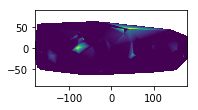

In [60]:
import matplotlib.pyplot as plt
plt.subplot(221)
#plt.imshow(grid_y.T, extent=(-180,180,-90,90), origin='lower')
plt.imshow(grid_z0.T, extent=(-180,180,-90,90), origin='lower')

In [115]:
ilen=l3r.time.shape[0]
gmap= np.zeros((1441,721))*np.nan
print(gmap.shape)
for i in range(0,ilen):
    ilon=int(round((l3r.lon.data[i]+179.875)/.25+1,0))
    ilat=int(round((l3r.lat.data[i]+89.875)/.25+1,0))
    gmap[ilon,ilat]=l3r.percent_land.data[i]

(1441, 721)


C:\Users\gentemann\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


nan

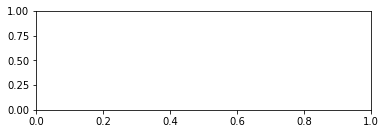

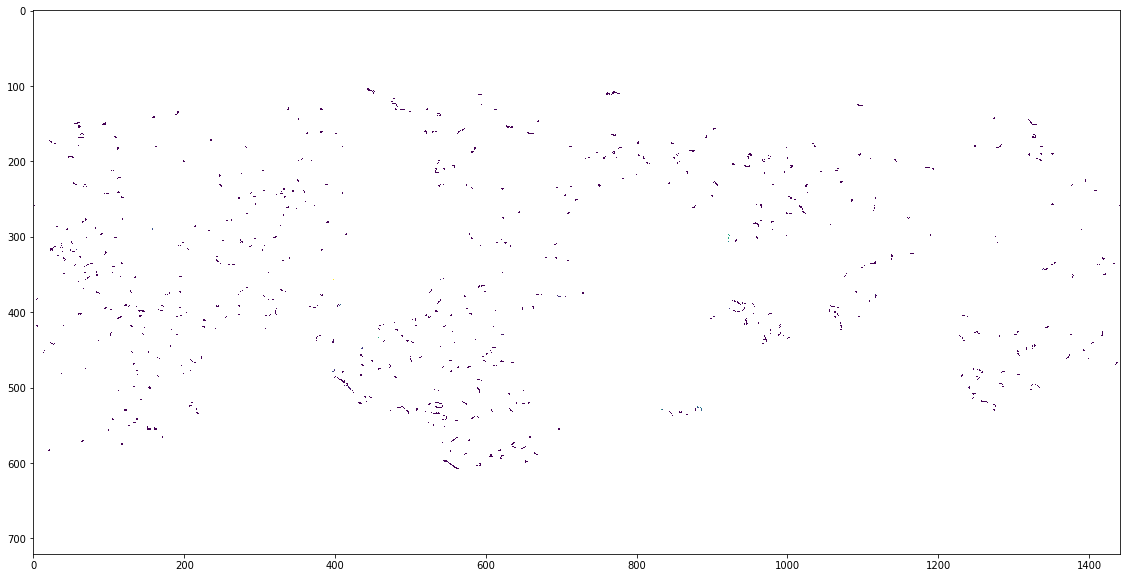

In [121]:
plt.subplot(211)
plt.figure(figsize=(20,10))
plt.imshow(gmap.T)